In [1]:
%pylab 
%matplotlib inline
import sympy
from control.matlab import *
from sympy import Poly
from sympy.abc import s, z
from IPython.display import display,Latex,Math

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


<div id="toc"></div>

# Introduction: PID Controller Design

In this tutorial we will introduce a simple yet versatile feedback compensator structure, the Proportional-Integral-Derivative (PID) controller. We will discuss the effect of each of the pid parameters on the closed-loop dynamics and demonstrate how to use a PID controller to improve the system performance.

## PID Overview

In this tutorial, we will consider the following unity feedback system:
![feedback_block.png](figures/feedback_block.png)
The output of a PID controller, equal to the control input to the plant, in the time-domain is as follows:

$$
u(t) = K_p e(t) + K_i \int e(t)dt + K_p \frac{de}{dt}
$$

First, let's take a look at how the PID controller works in a closed-loop system using the schematic shown above. The variable ($e$) represents the tracking error, the difference between the desired input value ($r$) and the actual output ($y$). This error signal ($e$) will be sent to the PID controller, and the controller computes both the derivative and the integral of this error signal. The control signal ($u$) to the plant is equal to the proportional gain ($K_p$) times the magnitude of the error plus the integral gain ($K_i$) times the integral of the error plus the derivative gain ($K_d$) times the derivative of the error. This control signal ($u$) is sent to the plant, and the new output ($y$) is obtained. The new output ($y$) is then fed back and compared to the reference to find the new error signal ($e$). The controller takes this new error signal and computes its derivative and its integral again, ad infinitum. The transfer function of a PID controller is found by taking the Laplace transform of Eq.(1).

$$
K_p + \frac {K_i} {s} + K_d s = \frac{K_d s^2 + K_p s + K_i} {s}
$$

\\(K_p\\) = Proportional gain \\(K_i\\) = Integral gain \\(K_d\\) = Derivative gain We can define a PID controller in MATLAB using the transfer function directly, for example:

In [10]:
# Helper Functions
def tex(eqn):
    # Quick way to display a symbolic equation.
    display(Math(sympy.latex(eqn)))
def sym_to_tf(sym_sys):
    # Convert symbolic equation into a transfer function.
    sym_num=sympy.Poly(sympy.numer(sym_sys),s)
    sym_den=sympy.Poly(sympy.denom(sym_sys),s)
    num = float64(sym_num.all_coeffs())
    den = float64(sym_den.all_coeffs())
    sys = tf(num,den)
    return sys

In [11]:
Kp = 1
Ki = 1
Kd = 1
C = Kp + Ki/s + Kd*s
tex(C)

<IPython.core.display.Math object>

## The Characteristics of P, I, and D Controllers

A proportional controller ($K_p$) will have the effect of reducing the rise time and will reduce but never eliminate the **steady-state error**. An integral control ($K_i$) will have the effect of eliminating the steady-state error for a constant or step input, but it may make the transient response slower. A derivative control ($K_d$) will have the effect of increasing the stability of the system, reducing the overshoot, and improving the transient response. The effects of each of controller parameters, $K_p$, $K_d$, and \\(K_i\\) on a closed-loop system are summarized in the table below. <html> <table border><center> <tr> <td><center><b> CL RESPONSE </center></b></td> <td><center> <b> RISE TIME </center></b></td> <td><center><b> OVERSHOOT </center></b></td> <td><center><b> SETTLING TIME </center></b></td> <td><center><b> S-S ERROR </center></b></td> <tr> <td> <b><center>Kp</center></b></td> <td><center>Decrease</center></td> <td><center>Increase</center></td> <td><center>Small Change</center></td> <td><center>Decrease</center></td> <tr> <td><b><center>Ki</center></b></td> <td><center>Decrease</center></td> <td><center>Increase</center></td> <td><center>Increase</center></td> <td><center>Eliminate</center></td> <tr> <td><b><center>Kd</center></b></td> <td><center>Small Change</center></td> <td><center>Decrease</center></td> <td><center>Decrease</center></td> <td><center> No Change </center></td> </table> </center> </html> Note that these correlations may not be exactly accurate, because $K_p$, $K_i$, and \\(K_d\\) are dependent on each other. In fact, changing one of these variables can change the effect of the other two. For this reason, the table should only be used as a reference when you are determining the values for $K_i$, \\(K_p\\) and $K_d$.

## Example Problem

Suppose we have a simple mass, spring, and damper problem.
![mass_spring_damper.png](figures/mass_spring_damper.png)
The modeling equation of this system is

$$
M\ddot{x} + b\dot{x} + kx = F
$$

Taking the Laplace transform of the modeling equation, we get

$$
Ms^{2}X(s) + bsX(s) + kX(s) = F(s)
$$

The transfer function between the displacement \\(X(s)\\) and the input \\(F(s)\\) then becomes

$$
\frac{X(s)}{F(s)} = \frac{1}{Ms^2 + bs + k}
$$

Let M = 1 kg b = 10 N s/m k = 20 N/m F = 1 N Plug these values into the above transfer function

$$
\frac{X(s)}{F(s)} = \frac{1}{s^2 + 10s + 20}
$$

The goal of this problem is to show you how each of $K_p$, \\(K_i\\) and \\(K_d\\) contributes to obtain Fast rise time Minimum overshoot No steady-state error

## Open-Loop Step Response

Let's first view the open-loop step response.

<IPython.core.display.Math object>

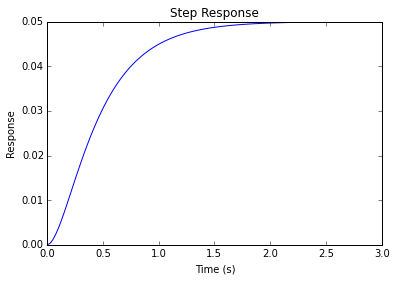

In [16]:
P = 1/(s**2 + 10*s + 20)
tex(P)
P2 = sym_to_tf(P)
y, t = step(P2)
plot(t,y)
xlabel('Time (s)')
ylabel('Response')
title("Step Response")

The DC gain of the plant transfer function is 1/20, so 0.05 is the final value of the output to an unit step input. This corresponds to the steady-state error of 0.95, quite large indeed. Furthermore, the rise time is about one second, and the settling time is about 1.5 seconds. Let's design a controller that will reduce the rise time, reduce the settling time, and eliminate the steady-state error.

## Proportional Control

From the table shown above, we see that the proportional controller (Kp) reduces the rise time, increases the overshoot, and reduces the steady-state error. The closed-loop transfer function of the above system with a proportional controller is:

$$
\frac{X(s)}{F(s)} = \frac{K_p}{s^2 + 10s + (20 + K_p)}
$$

Let the proportional gain ($K_p$) equal 300 and change the m-file to the following:

In [18]:
Kp = 300
T = feedback(Kp*P2,1)
# t = 0:0.01:2;
# step(T,t)

The above plot shows that the proportional controller reduced both the rise time and the steady-state error, increased the overshoot, and decreased the settling time by small amount.

## Proportional-Derivative Control

Now, let's take a look at a PD control. From the table shown above, we see that the derivative controller (Kd) reduces both the overshoot and the settling time. The closed-loop transfer function of the given system with a PD controller is:

$$
\frac{X(s)}{F(s)} = \frac{K_d s + K_p}{s^2 + (10 + K_d) s + (20 + K_p)}
$$

Let \\(K_p\\) equal 300 as before and let \\(K_d\\) equal 10. Enter the following commands into an m-file and run it in the MATLAB command window.

In [7]:
# Kp = 300;
# Kd = 10;
# C = pid(Kp,0,Kd)
# T = feedback(C*P,1)
# t = 0:0.01:2;
# step(T,t)

This plot shows that the derivative controller reduced both the overshoot and the settling time, and had a small effect on the rise time and the steady-state error.

## Proportional-Integral Control

Before going into a PID control, let's take a look at a PI control. From the table, we see that an integral controller (Ki) decreases the rise time, increases both the overshoot and the settling time, and eliminates the steady-state error. For the given system, the closed-loop transfer function with a PI control is:

$$
\frac{X(s)}{F(s)} = \frac{K_p s + K_i}{s^3 + 10 s^2 + (20 + K_p s + K_i)}
$$

Let's reduce the \\(K_p\\) to 30, and let \\(K_i\\) equal 70. Create an new m-file and enter the following commands.

In [8]:
# Kp = 30;
# Ki = 70;
# C = pid(Kp,Ki)
# T = feedback(C*P,1)
# t = 0:0.01:2;
# step(T,t)

Run this m-file in the MATLAB command window, and you should get the following plot. We have reduced the proportional gain (Kp) because the integral controller also reduces the rise time and increases the overshoot as the proportional controller does (double effect). The above response shows that the integral controller eliminated the steady-state error.

## Proportional-Integral-Derivative Control

Now, let's take a look at a PID controller. The closed-loop transfer function of the given system with a PID controller is:

$$
\frac{X(s)}{F(s)} = \frac{K_d s^2 + K_p s + K_i}{s^3 + (10 + K_d)s^2 + (20 + K_p)s + K_i }
$$

After several trial and error runs, the gains \\(K_p\\) = 350, \\(K_i\\) = 300, and \\(K_d\\) = 50 provided the desired response. To confirm, enter the following commands to an m-file and run it in the command window. You should get the following step response.

In [9]:
# Kp = 350;
# Ki = 300;
# Kd = 50;
# C = pid(Kp,Ki,Kd)
# T = feedback(C*P,1);
# t = 0:0.01:2;
# step(T,t)

Now, we have obtained a closed-loop system with no overshoot, fast rise time, and no steady-state error.

## General Tips for Designing a PID Controller

When you are designing a PID controller for a given system, follow the steps shown below to obtain a desired response. # Obtain an open-loop response and determine what needs to be improved # Add a proportional control to improve the rise time # Add a derivative control to improve the overshoot # Add an integral control to eliminate the steady-state error # Adjust each of Kp, Ki, and Kd until you obtain a desired overall response. You can always refer to the table shown in this "PID Tutorial" page to find out which controller controls what characteristics. Lastly, please keep in mind that you do not need to implement all three controllers (proportional, derivative, and integral) into a single system, if not necessary. For example, if a PI controller gives a good enough response (like the above example), then you don't need to implement a derivative controller on the system. Keep the controller as simple as possible.

## Automatic PID Tuning

MATLAB provides tools for automatically choosing optimal PID gains which makes the trial and error process described above unnecessary. You can access the tuning algorithm directly using **pidtune** or through a nice graphical user interface (GUI) using **pidtool**. The MATLAB automated tuning algorithm chooses PID gains to balance performance (response time, bandwidth) and robustness (stability margins). By default the algorthm designs for a 60 degree phase margin. Let's explore these automated tools by first generating a proportional controller for the mass-spring-damper system by entering the following commands: <html> <pre class="codeinput"> pidtool(P,'p') </pre> </html> The pidtool GUI window, like that shown below, should appear.
![pidtool_1.png](figures/pidtool_1.png)
Notice that the step response shown is slower than the proportional controller we designed by hand. Now click on the **Show Parameters** button on the top right.  As expected the proportional gain constant, Kp, is lower than the one we used, Kp = 94.85 < 300. We can now interactively tune the controller parameters and immediately see the resulting response int he GUI window.  Try dragging the resposne time slider to the right to 0.14s, as shown in the figure below. The response does indeeed speed up, and we can see Kp is now closer to the manual value. We can also see all the other performance and robustness parameters for the system.  Note that the phase margin is 60 degrees, the default for pidtool and generally a good balance of robustness and performance.
![pidtool_2.png](figures/pidtool_2.png)
Now let's try designing a PID controller for our system. By specifying the previously designed or (baseline) controller, C, as the second parameter, pidtool will design another PID controller (instead of P or PI) and will compare the response of the system with the automated controller with that of the baseline. <html> <pre class="codeinput"> pidtool(P,C) </pre> </html> We see in the output window that the automated controller responds slower and exhibits more overshoot than the baseline. Now choose the *Design Mode: Extended* option at the top, which reveals more tuning parameters.
![pidtool_3.png](figures/pidtool_3.png)
Now type in *Bandwidth: 32 rad/s** and **Phase Margin: 90 deg* to generate a controller similar in performance to the baseline.  Keep in mind that a higher bandwidth (0 dB crossover of the open-loop) results in a faster rise time, and a higher phase margin reduces the overshoot and improves the system stability. Finally we note that we can generate the same controller using the command line tool **pidtune** instead of the pidtool GUI

In [10]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>